# Testing Theano

**Theano** is built around tensors that can be seen as generalizations of scalars, vectors, matrices and so on. A scalar can be defined as a rank-0 tensor, a vector as a rank-1 tensor, etc.

Now we will compute a net input $z$ of a sample point $x$ in a one dimensional dataset with weight $w_1$ and bias $w_0$:

$$
z = x_1 \times w_1 + w_0
$$

In [1]:
import theano
from theano import tensor as T

# initialize symbols
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = x1 * w1 + w0

# compile code
net_input = theano.function(inputs=[w1,x1,w0], outputs=z1)

# run the code
print("Net input: %.2f" % net_input(2.0, 1.0, 0.5))

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



Net input: 2.50


Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


Writing code in Theano follows three simple steps:

- Define the *symbols* (Variable objects)
- Compile the code
- And execute

Anyway we have to remember to configure Theano correctly and switch back and forth between *float64* to work with CPU and *float32* to work with GPU.

In [2]:
print(theano.config.floatX)

float32


## Working with array structures

We will create a 2x3 matrix and calculate the column sums

In [3]:
import numpy as np

x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

calc_sum = theano.function(inputs=[x], outputs=x_sum)

ary = [[1,2,3],[1,2,3]]
print("Columns sum: ", calc_sum(ary))

Columns sum:  [ 2.  4.  6.]


In [4]:
ary = np.array([[1,2,3],[1,2,3]], dtype=theano.config.floatX)
print("Columns sum: ", calc_sum(ary))

Columns sum:  [ 2.  4.  6.]


Theano has a smart memory management system that reuses memory, in practice it spreads memory space across multiple devices. We take a look at the *shared* variable which allows us to share large objects and grants multiple functions read and write access, so we can modify those objects after compilation.

In [5]:
# initialize
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[x], updates=update, outputs=z)

# execute
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


We defined an update variable where we declared that we want to update an array w by a value 1.0 after each iteration in the for loop. 

Another trick is to use the *givens* variable to insert values into the graph before compiling it. In this way we can reduce the number of transfers from RAM to CPU and GPU. By using the *inputs* parameter in *theano.function* data is moved between CPU and GPU multiple times. By using *givens* we can keep data on the GPU if it fits in memory.

In [6]:
# initialize
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[], updates=update, givens={x: data}, outputs=z)

# execute
for i in range(5):
    print('z%d:', net_input())

z%d: [[ 0.]]
z%d: [[ 6.]]
z%d: [[ 12.]]
z%d: [[ 18.]]
z%d: [[ 24.]]


## Linear regression example

Let's implement **OLS (Ordinary Least Squares)** in Theano. We start by defining a toy dataset.

In [7]:
x_train = np.asarray([[0.0], [1.0],
                      [2.0], [3.0],
                      [4.0], [5.0],
                      [6.0], [7.0],
                      [8.0], [9.0]], dtype=theano.config.floatX)
y_train = np.asarray([1.0, 1.3, 3.1, 2.0,
                      5.0, 6.3, 6.6, 7.4,
                      8.0, 9.0], dtype=theano.config.floatX)

Now we have to implement a training function to learn the weights of the linear regression model. Note that $w_0$ is the bias unit (in this case the intercept at x=0).

In [8]:
def train_linreg(x_train, y_train, eta, epochs):
    costs = []
    eta0 = T.fscalar('eta0')
    y = T.fvector(name='y')
    x = T.fmatrix(name='x')
    w = theano.shared(np.zeros(shape=(x_train.shape[1] + 1), 
                               dtype=theano.config.floatX),
                     name='w')
    
    # calculate cost
    net_input = T.dot(x, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2))
    
    # gradient update
    gradient = T.grad(cost, wrt=w)
    update = [(w, w - eta0 * gradient)]
    
    # compile model
    train = theano.function(inputs=[eta0],
                            outputs=cost,
                            updates=update,
                            givens={x: x_train, 
                                    y: y_train})
    for _ in range(epochs):
        costs.append(train(eta))
    
    return costs, w

A nice Theano feature is the **grad** function that computes the derivative of an expression with respect to its parameters as the *wrt* argument.

In [9]:
import matplotlib.pyplot as plt

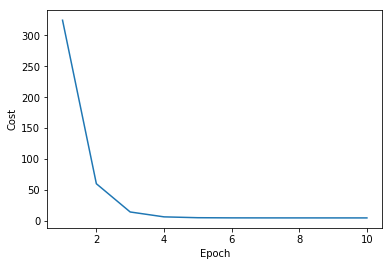

In [10]:
costs, w = train_linreg(x_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs)+1), costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

By looking at the cost function above it seems that we built a working regression model, now we just have to define a function to make predictions based on the inputs

In [11]:
def predict_linreg(x, w):
    xt = T.matrix(name='x')
    net_input = T.dot(xt, w[1:]) + w[0]
    predict = theano.function(inputs=[xt], givens={w: w}, 
                              outputs=net_input)
    return predict(x)

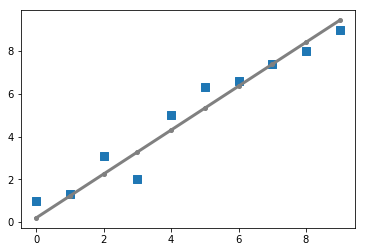

In [12]:
plt.scatter(x_train, y_train, marker='s', s=50)
plt.plot(range(x_train.shape[0]), predict_linreg(x_train, w),
         color='gray', marker='o', markersize=4, linewidth=3)
plt.show()

## Choosing activation functions for feedforward neural networks

Up to now we always used **sigmoid** activation functions, but there are many more that can be used and in theory we can use any function as an activation function.

**Log-likelihood** (the same as sigmoid) is surely better than a linear function since we can solve more complex problems, but there are some issues. For instance, if we have highly negative inputs they will be close to zero and the net will learn very slowly with the risk of remaining trapped in a local minima.

This is the reason why people prefer to use a **hyperbolic tangent** in hidden layers.

### Logistic function recap

The **logistic function** is a special case of a sigmoid function, as we may recall we have:

$$
\phi_{logistic}(z) = \frac{1}{1+e^{-z}}
$$

Where $z$:

$$
\sum_{j=0}^{m}=x_j w_j = \textbf{w}^T\textbf{x}
$$

Let's assume a model for a 2D data point x and a model with the following weight coefficients assigned to the vector w

In [13]:
x = np.array([1, 1.4, 1.5])
w = np.array([0.0, 0.2, 0.4])

def net_input(x, w):
    z = x.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(x, w):
    z = net_input(x, w)
    return logistic(z)

print("P(y=1|x) = %.3f" % logistic_activation(x, w))

P(y=1|x) = 0.707


If we use the calculated *net input* to activate a logistic neuron we get back a value of 0.707, that we can see as a 70.7% probability that $x$ belongs to the positive class.

In the previous chapter we used one-hot encoding to compute the values in the output layer consisiting of multiple logistic activation functions. The problem is that an output coming from multiple logistic functions doesn't return meaningful probability values.

To prove it we will imagine to have a **MLP perceptron** with 3 hidden units and 1 bias unit in the hidden unit, the output layer consists of 3 output units.

In [14]:
# w : array, shape = [n_output_units, n_hidden_units+1]
#          Weight matrix for hidden layer -> output layer.
# note that first column (w[:][0]) contains the bias units
w = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])

# a : array, shape = [n_hidden+1, n_samples]
#          Activation of hidden layer.
# note that first element (a[0][0] = 1) is for the bias units

a = np.array([[1.0], 
              [0.1], 
              [0.3], 
              [0.7]])

# z : array, shape = [n_output_units, n_samples]
#          Net input of output layer.

z = w.dot(a) 
y_probas = logistic(z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


The probabilities we get don't make much sense since we would expect that adding them together would make 1, but we don't have to concern about this issue if we have to just get class labels. But in some settings it can be useful to return probabilities.

In [15]:
y_class = np.argmax(z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


### Estimating probabilities in multi-class classification via the softmax function

The **softmax** function is a generalization of the logistic function that allows us to return meaningful probabilities in multi-class problems (*multinomial logistic regression*). The probability of a particular sample with net input $z$ belongs to the $i$th class can be computed with a normalization term $M$.

$$
P(y=i | z) = \phi_{softmax}(z) = \frac{e_{i}^{z}}{ \sum_{m=1}^{M} e_{m}^{z}}
$$

In [16]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(x, w):
    z = net_input(x, w)
    return softmax(z)

y_probas = softmax(z)
print("Probabilities:\n", y_probas); print(y_probas.sum())

Probabilities:
 [[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]
1.0


As we can see now the probabilities sum up to one while the predicted class remains the same. We can see the **softmax** as a normalized logistic function.

### Hyperbolic tangent

Another sigmoid function often used is the **hyperbolic tangent (tanh)** which can be seen as a rescaled version of a logistic function:

$$
\phi_{tanh}(z)=2 \times \phi_{logistic}(2 \times z)-1= \frac{e^z-e^{-z}}{e^z+e^{-z}}
$$

The advantage of tanh is that has a broader output spectrum and ranges the interval $(-1, 1)$, which can improve the convergence of the back propagation algorithm. To better understand what's the difference between the two let's plot them.

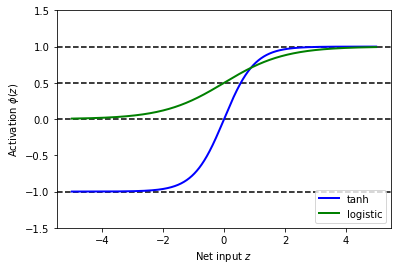

In [18]:
import matplotlib.pyplot as plt

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel("Net input $z$")
plt.ylabel("Activation $\phi(z)$")
plt.axhline(1, color="black", linestyle="--")
plt.axhline(0.5, color="black", linestyle="--")
plt.axhline(0, color="black", linestyle="--")
plt.axhline(-1, color="black", linestyle="--")

plt.plot(z, tanh_act, linewidth=2, color="blue",
         label="tanh")
plt.plot(z, log_act, linewidth=2, color="green",
         label="logistic")

plt.legend(loc="lower right")
plt.show()

It's easy to see how **tanh** has a double larger output than the logistic function. Besides we implemented both function from scratch for illustration purposes, but we can use:

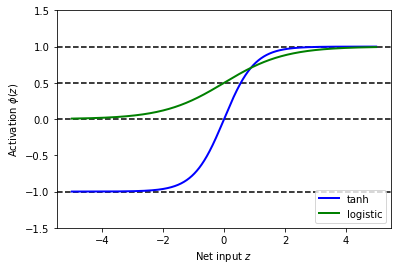

In [19]:
# tanh
tanh_act = np.tanh(z)

# logistic
from scipy.special import expit
log_act = expit(z)

plt.ylim([-1.5, 1.5])
plt.xlabel("Net input $z$")
plt.ylabel("Activation $\phi(z)$")
plt.axhline(1, color="black", linestyle="--")
plt.axhline(0.5, color="black", linestyle="--")
plt.axhline(0, color="black", linestyle="--")
plt.axhline(-1, color="black", linestyle="--")

plt.plot(z, tanh_act, linewidth=2, color="blue",
         label="tanh")
plt.plot(z, log_act, linewidth=2, color="green",
         label="logistic")

plt.legend(loc="lower right")
plt.show()

## Efficient training with Keras

To see how **[Keras](https://keras.io/)** works we will implement a multilayer perceptron to classify handwritten digits in the **mnist** dataset.

In [10]:
import os 
import struct
import numpy as np

def load_mnist(path, kind="train"):
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [11]:
x_train, y_train = load_mnist("mnist", kind="train")
print("Rows %d, cols %d" % (x_train.shape[0], x_train.shape[1]))

Rows 60000, cols 784


In [12]:
x_test, y_test = load_mnist("mnist", kind="t10k")
print("Rows %d, cols %d" % (x_test.shape[0], x_test.shape[1]))

Rows 10000, cols 784


In [13]:
import theano

theano.config.floatX = "float32"
x_train = x_train.astype(theano.config.floatX)
x_test = x_test.astype(theano.config.floatX)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


In [16]:
from keras.utils import np_utils

print("First 3 labels: ", y_train[:3])

First 3 labels:  [5 0 4]


In [15]:
%%bash 
KERAS_BACKEND=theano python -c "from keras import backend"

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


In [18]:
y_train_ohe = np_utils.to_categorical(y_train)
print("First 3 labels (one-hot):\n", y_train_ohe[:3])

First 3 labels (one-hot):
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


After loading and preparing the dataset we can get to the fun part: building the neural network. We will use the same architecture as in Ch 12, but we will replace the logistic units in the hidden layer with tanh functions, replace the logistic function in the output layer with softmax and add an additional hidden layer.

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1)

In [24]:
model = Sequential()
model.add(Dense(input_dim=x_train.shape[1],
                output_dim=50,
                init="uniform",
                activation="tanh"))
model.add(Dense(input_dim=50,
                output_dim=50,
                init="uniform",
                activation="tanh"))
model.add(Dense(input_dim=50,
                output_dim=y_train_ohe.shape[1],
                init="uniform",
                activation="softmax"))
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

/home/alan/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=784, activation="tanh", units=50, kernel_initializer="uniform")`
/home/alan/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="tanh", units=50, kernel_initializer="uniform")`
/home/alan/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="softmax", units=10, kernel_initializer="uniform")`


In [25]:
model.fit(x_train, y_train_ohe,
          epochs=50, batch_size=300,
          verbose=1, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 0s - loss: 2.2337 - acc: 0.3970 - val_loss: 2.1200 - val_acc: 0.6028